In [43]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from scipy.interpolate import griddata
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import cartopy as cart
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from datetime import timedelta as delta
from datetime import datetime

import networkx as nx

from parcels import (grid, Field, FieldSet, ParticleSet, JITParticle, ScipyParticle, AdvectionRK4,
                     ErrorCode, ParticleFile, Variable, plotTrajectoriesFile)

from importlib import reload
import sys
sys.path.append('/home/students/4302001/arctic-connectivity/tools')
sys.path.append('/Users/daanreijnders/surfdrive/Thesis/repo/tools')
import plot
import lifeline
import comtools
import fieldsetter
import advectParticles

In [44]:
reload(plot)
reload(lifeline)
reload(comtools)
reload(fieldsetter)
reload(advectParticles)

<module 'advectParticles' from '/home/students/4302001/arctic-connectivity/tools/advectParticles.py'>

In [3]:
# Specify paths to velocity field and mesh
# readdir_ocean = '/Users/daanreijnders/Datasets/'
# readdir_ice = '/Users/daanreijnders/Datasets/'
# readdir_mesh = '/Users/daanreijnders/Datasets/'

readdir_ice = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ice/arctic/'
readdir_ocean = '/data/oceanparcels/input_data/CESM/0.1_deg/control/ocean/arctic/'
readdir_mesh = '/scratch/DaanR/fields/'

fieldfile_ocean = 'daily_CESM_0.1degree_controlrun_year_300_arctic_timed_no_cord.nc'
fieldfile_ice = 'monthly_icefields_CESM_0.1degree_controlrun_year_300_arctic.nc'
meshfile = 'POP_grid_coordinates.nc'

writedir = ''

In [4]:
fieldset = fieldsetter.read_velocity_field(readdir_ocean+fieldfile_ocean, meshfile=readdir_mesh+meshfile)  

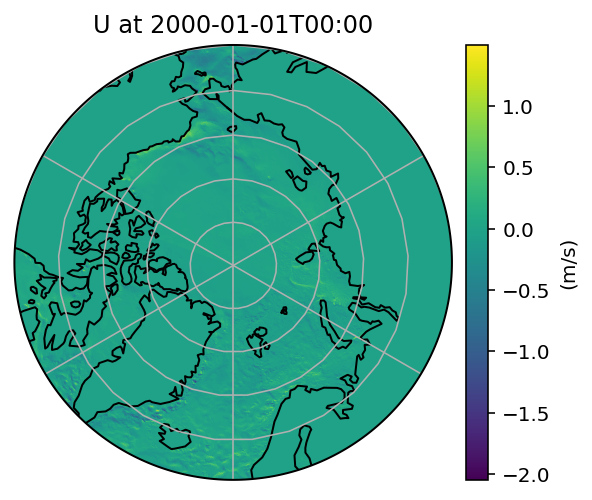

In [5]:
plot.from_field(fieldset.U, polar=True, land=False, latRange=(60,90))

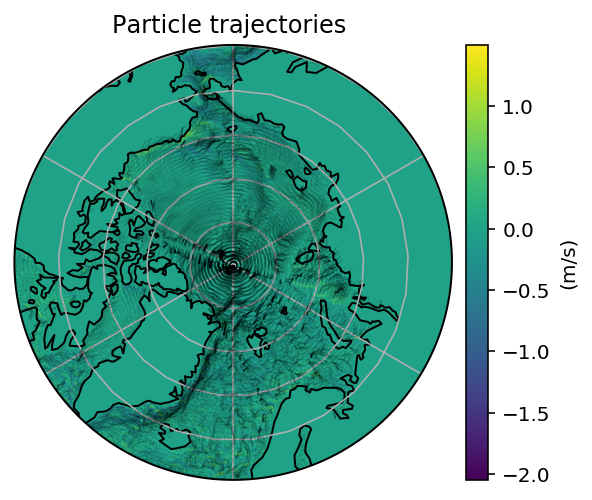

In [67]:
plot.from_field(fieldset.U, trajectoryFile='/data/oceanparcels/output_data/data_Daan/pset_control_y300_P359x59.nc', polar=True, land=False, latRange=(60,90))

In [59]:
#add_ice_fields(fieldset, readdir_ice+fieldfile_ice, meshfile=readdir_mesh+meshfile)

In [64]:
countG = comtools.countGrid(240, 40)

In [65]:
particleG = comtools.particleGrid(3590, 590, release_time=datetime(2000,1,1))
particleG.remove_on_land(fieldset)

<Figure size 432x288 with 0 Axes>

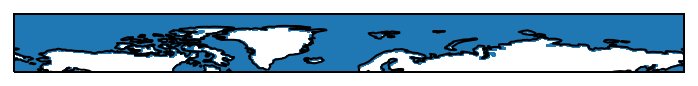

In [66]:
fig = plt.figure()
ax = particleG.show()

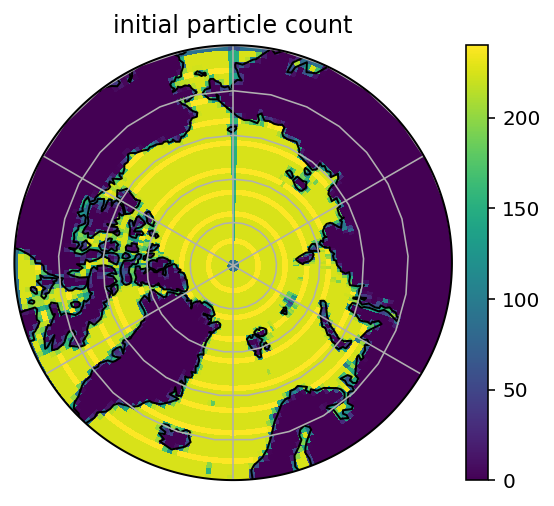

In [67]:
initCount = countG.particleCount(particleG).T
plot.from_dataset(countG.lonBounds, countG.latBounds, initCount, latRange=(60,90), title='initial particle count', polar=True, size=(12,4))

In [68]:
print("Sum of initCount on particleGrid:", countG.particleCount(particleG).sum())
print("Initial particle count:", particleG.initialParticleCount)
print("Removed particle count:", particleG.removedParticleCount)
print("Particle count:", particleG.particleCount)

Sum of initCount on particleGrid: 1338532.0
Initial particle count: 2118100
Removed particle count: 1338532
Particle count: 1338532


In [69]:
# #ADVECTION TAKES PLACE HERE
# psetTest = advectParticles.gridAdvection(fieldset, particleG, experiment_name='test_lr')

In [70]:
#particleG.add_advected('/data/oceanparcels/output_data/data_Daan/pset_control_y300_P3590x590_S2000-7-1_D30_DT5_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc')

In [72]:
advected_ds = xr.open_dataset('/data/oceanparcels/output_data/data_Daan/pset_control_y300_P3590x590_S2000-1-1_D30_DT5_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc')

In [73]:
advected_ds

<xarray.Dataset>
Dimensions:     (obs: 61, traj: 2118100)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) int32 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.0.0b3.dev93+g5cdb2e5
    parcels_mesh:           spherical

In [ ]:
fig = plt.figure()
ax = particleG.show(tindex=1)

In [ ]:
plot.from_dataset(countG.lonBounds, countG.latBounds, countG.particleCount(particleG, tindex=1).T, latRange=(60,90), title='final particle count', polar=True, size=(12,4), vmax=240)

 Determining particle bins. 100.0%

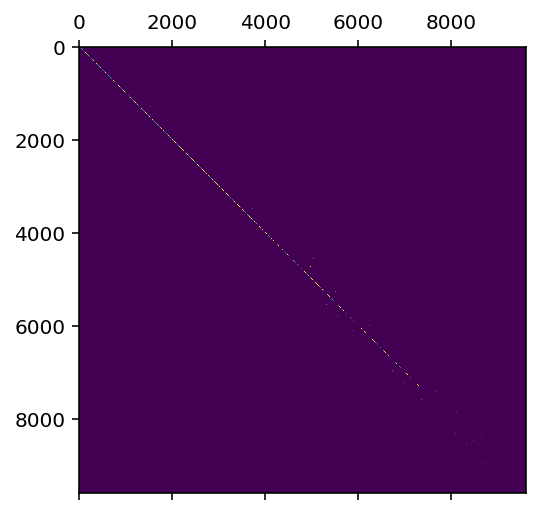

In [16]:
mytransmat = comtools.createTransition('/data/oceanparcels/output_data/data_Daan/pset_control_y300_P3590x590_S2000-7-1_D30_DT5_ODT12_LAT60.5-89.5_LON-179.5-179.5.nc', countG)
plt.matshow(mytransmat.data)
plt.show()

In [17]:
# Create network from numpy array (adjacency matrix)
G = nx.from_numpy_matrix(mytransmat.data, create_using=nx.DiGraph())
# Export to Pajek (.net) format for further manual processing
nx.write_pajek(G, 'out/graph_control_y300_P3590x590_S2000-7-1_D30_DT5_ODT12_LAT60.5-89.5_LON-179.5-179.5_C240x40.net')

In [8]:
countG.load_communities('out/graph_control_y300_P3590x590_S2000-7-1_D30_DT5_ODT12_LAT60.5-89.5_LON-179.5-179.5_C240x40.clu')

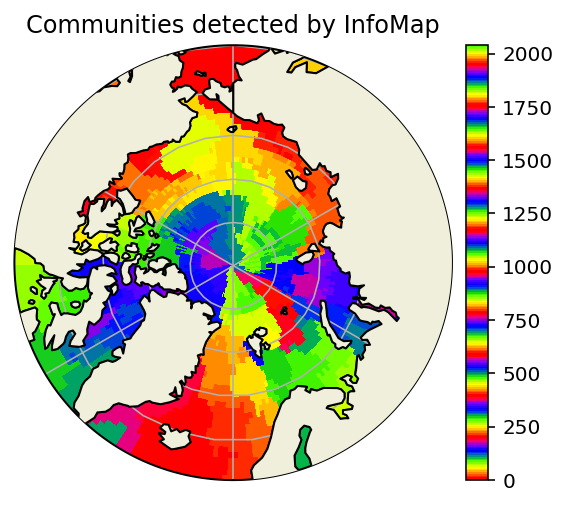

In [9]:
plot.from_dataset(countG.lonBounds, 
                  countG.latBounds, 
                  countG.community_map, 
                  colormap='prism', 
                  title='Communities detected by InfoMap',
                  polar=True, 
                  land=True, 
                  latRange=(60,90),
                  export='hr_communities_polar_land_summer.png')

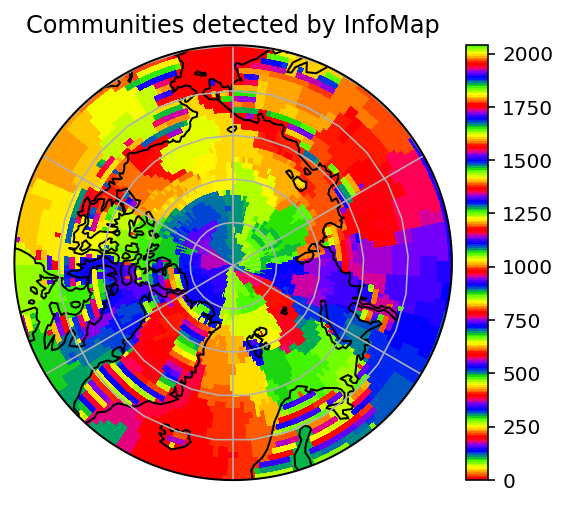

In [10]:
plot.from_dataset(countG.lonBounds, 
                  countG.latBounds, 
                  countG.community_map, 
                  colormap='prism', 
                  title='Communities detected by InfoMap',
                  polar=True, 
                  land=False, 
                  latRange=(60,90),
                  export='hr_communities_polar_summer.png')

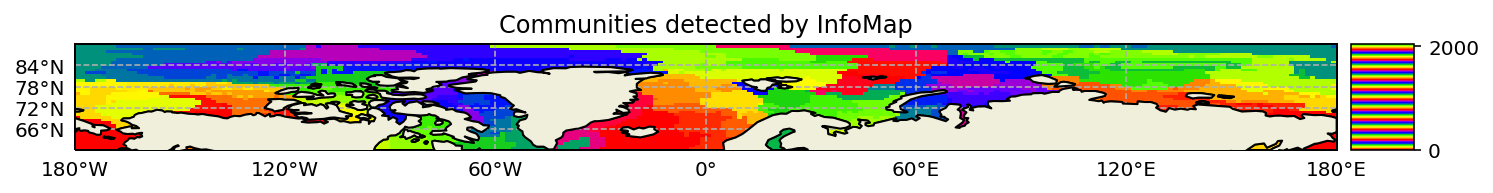

In [11]:
plot.from_dataset(countG.lonBounds, 
                  countG.latBounds, 
                  countG.community_map, 
                  title='Communities detected by InfoMap',
                  colormap='prism', 
                  land=True, 
                  latRange=(60,90), 
                  export="hr_communities_land_summer.png", 
                  size=(12,4))

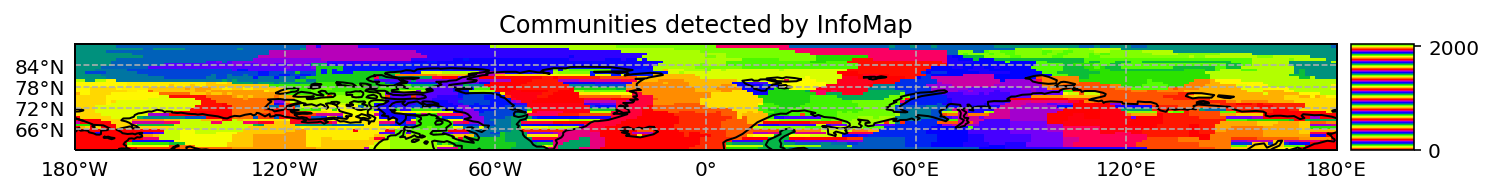

In [12]:
plot.from_dataset(countG.lonBounds, 
                  countG.latBounds, 
                  countG.community_map, 
                  title='Communities detected by InfoMap',
                  colormap='prism', 
                  land=False, 
                  latRange=(60,90), 
                  export="hr_communities_summer.png", 
                  size=(12,4))